# Demo of graph optimisation to segment dummy structures

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


In [2]:
from grace.base import GraphAttrs
from grace.models.optimise import optimise_graph
from grace.simulate import random_graph, random_graph_mixed_motifs


### Synthesize a fake image:

In [38]:
value = 0.5
scale = 3500
image_shape = (scale, scale)

In [39]:
image = np.zeros(shape=(scale, scale), dtype=np.float32)
image += value
image


array([[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       ...,
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]], dtype=float32)

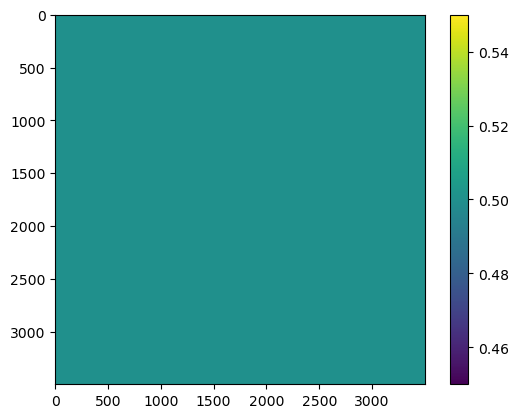

In [40]:
plt.imshow(image)
plt.colorbar()
plt.show()

### Load a dummy graph:

In [41]:
G = random_graph(n_motifs=5, n_chaff=100, scale=scale, density=0.025, motif="line")

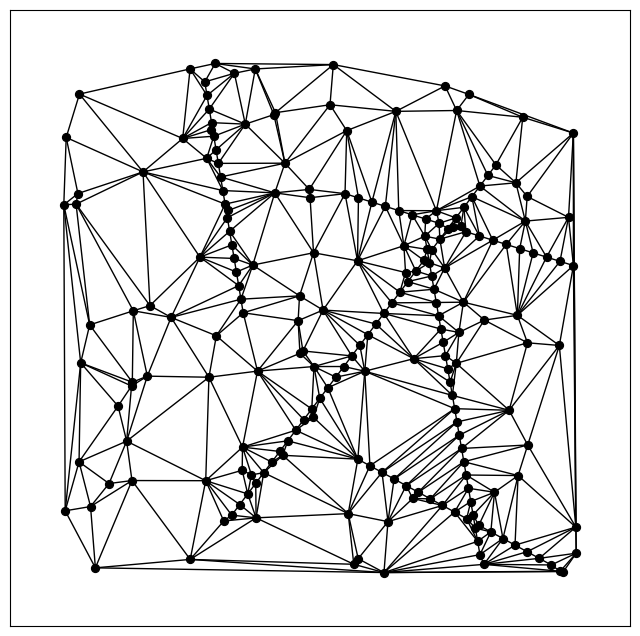

In [42]:
pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in G.nodes(data=True)}
fig, ax = plt.subplots(figsize=(8, 8))

# draw all nodes/vertices in the graph, including those not determined to be part of the objects
nx.draw_networkx(G, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32)

### Update the graph with bimodal node & edge predictions:

In [43]:
# NOTE(arl): this is *super* hacky - just to see if the optimisation works

def update_graph_dummy(G):

    nodes = list(G.nodes.data())

    for _, node in nodes:
        pd = np.random.random()*0.5
        if node["label"] > 0:
            node[GraphAttrs.NODE_PREDICTION] = pd
        else:
            node[GraphAttrs.NODE_PREDICTION] = 1-pd

    
    for edge in G.edges.data():
        pd = np.random.random()*0.1
        _, e_i = nodes[edge[0]]
        _, e_j = nodes[edge[1]]
        
        if e_i["object_idx"] == e_j["object_idx"] and e_i["label"] > 0:
            edge[2][GraphAttrs.EDGE_PREDICTION] = 1 - pd
        else:
            edge[2][GraphAttrs.EDGE_PREDICTION] = pd 


In [44]:
update_graph_dummy(G)


### Project the nodes into the image:

In [45]:
coords = np.transpose([pos[item] for item in pos.keys()])
coords.shape, coords[0].min(), coords[0].max(), coords[1].min(), coords[1].max()

((2, 213),
 9.114281308947369,
 3498.606748585627,
 5.754920502714922,
 3455.292723853911)

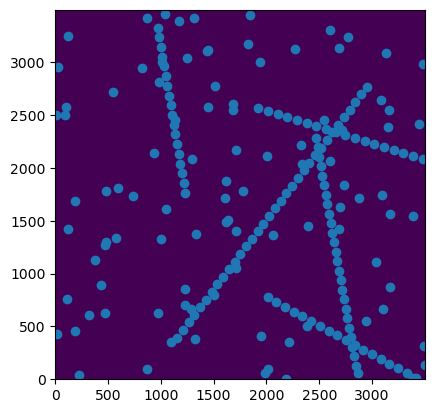

In [46]:
plt.imshow(image, origin="lower")
plt.scatter(x=coords[0], y=coords[1])


In [47]:
# Separate the real nodes from the fake nodes:

real_nodes, fake_nodes = [], []

for idx, node in G.nodes.data():
    if node['label'] > 0:
        real_nodes.append([node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]])
    else:
        fake_nodes.append([node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]])

real_coords = np.array(real_nodes)
fake_coords = np.array(fake_nodes)
real_coords.shape, fake_coords.shape

((113, 2), (100, 2))

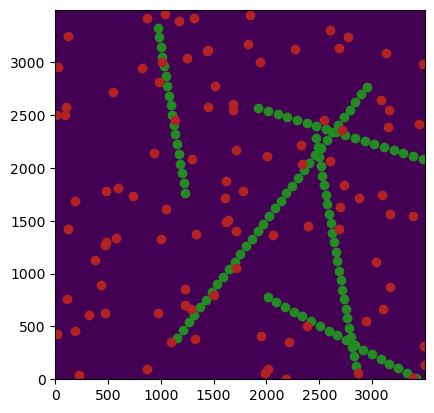

In [48]:
plt.imshow(image, origin="lower")
plt.scatter(x=real_coords[:, 0], y=real_coords[:, 1], color='forestgreen')
plt.scatter(x=fake_coords[:, 0], y=fake_coords[:, 1], color='firebrick')


##### Visualise how the edge weights are distributed:


In [49]:
def plot_node_and_edge_label_distribution(graph: nx.Graph) -> None: 

    node_true = [node['label'] for _, node in graph.nodes(data=True)]
    # node_pred = [node['node_prediction'] for _, node in graph.nodes(data=True)]

    real_node_pred = [node['node_prediction'] for _, node in graph.nodes(data=True) if node['label'] > 0]
    fake_node_pred = [node['node_prediction'] for _, node in graph.nodes(data=True) if node['label'] <= 0]

    plt.hist(real_node_pred, color="forestgreen", label=f"Real nodes ({len(real_node_pred)})")
    plt.hist(fake_node_pred, color="firebrick", label=f"Fake nodes ({len(fake_node_pred)})")
    plt.title(f"Distribution of synthetic prediction values in {len(real_node_pred) + len(fake_node_pred)} nodes")
    plt.legend()
    plt.show()



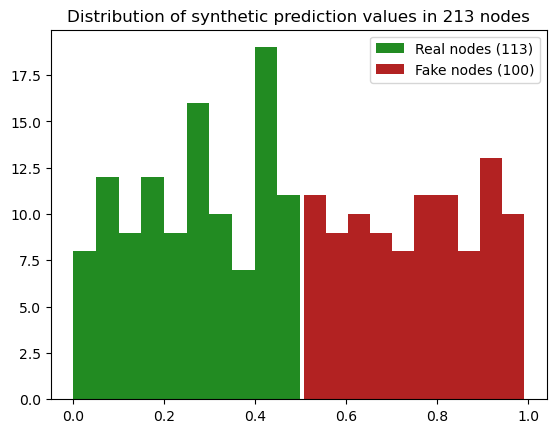

In [50]:
plot_node_and_edge_label_distribution(graph=G)

### Now read the coords of real & fake nodes & color-code the image accordingly:

In [51]:
real_coords.shape

(113, 2)

In [57]:
patch_shape = (112, 112)
patch_black = np.zeros(shape=patch_shape, dtype=image.dtype)
patch_white = np.ones(shape=patch_shape, dtype=image.dtype)

img = np.pad(image, pad_width=patch_shape, mode='constant', constant_values=value)
print (image.shape, img.shape)

for _, node in G.nodes.data():
    coords = node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]
    st_x, en_x = int(coords[0]) + patch_shape[0] - patch_shape[0] // 2, int(coords[0]) + patch_shape[0] + patch_shape[0] // 2
    st_y, en_y = int(coords[1]) + patch_shape[1] - patch_shape[1] // 2, int(coords[1]) + patch_shape[1] + patch_shape[1] // 2

    print (coords, node['label'], "points", st_x, en_x, st_y, en_y)

    if node['label'] > 0:  # real
        img[st_x:en_x, st_y:en_y] = patch_white
    else:
        img[st_x:en_x, st_y:en_y] = patch_black

image = img[patch_shape[0]:-patch_shape[0], patch_shape[1]:-patch_shape[1]]
image.shape

(3500, 3500) (3724, 3724)
(1098.4510862967688, 354.9915725692627) 0 points 1154 1266 410 522
(2270.335450295912, 3130.6743407384733) 0 points 2326 2438 3186 3298
(437.05160797461355, 896.0121584992244) 0 points 493 605 952 1064
(1286.9337815852034, 667.700569642597) 0 points 1342 1454 723 835
(869.9925825420096, 94.69251324323002) 0 points 925 1037 150 262
(3496.020461405034, 313.49134620809724) 0 points 3552 3664 369 481
(818.6864666625087, 2946.8570172650857) 0 points 874 986 3002 3114
(18.589570348185426, 424.0746881022619) 0 points 74 186 480 592
(997.4475261068234, 1329.2042110298667) 0 points 1053 1165 1385 1497
(1013.1239763710067, 3006.6288066544043) 0 points 1069 1181 3062 3174
(2730.5256565200193, 1837.8099655139154) 0 points 2786 2898 1893 2005
(112.972716190958, 756.0266446616888) 0 points 168 280 812 924
(3389.4825588356216, 14.487633327252281) 0 points 3445 3557 70 182
(191.23776591301223, 452.9795111606935) 0 points 247 359 508 620
(1983.9348864005485, 61.76152652667316)

(3500, 3500)

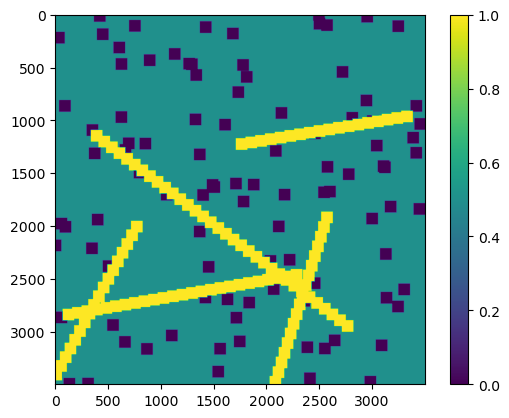

In [58]:
plt.imshow(image)
plt.colorbar()

### Visualise the optimised graph & individual objects:

In [66]:
x = optimise_graph(G)

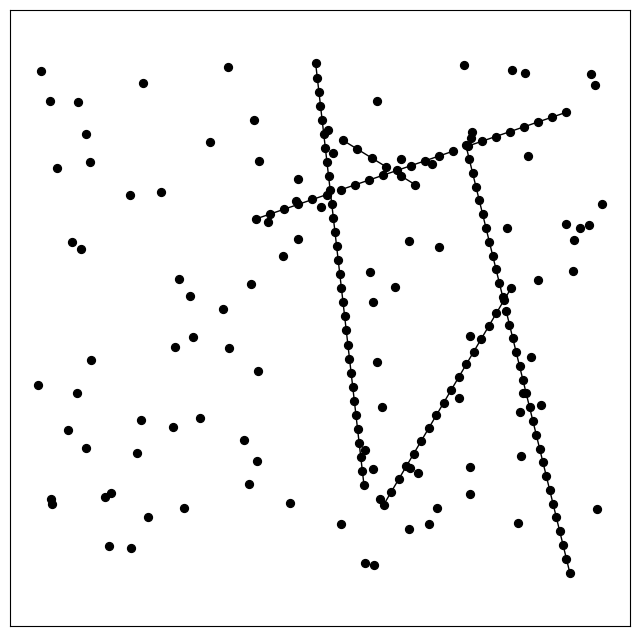

In [67]:
pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in x.nodes(data=True)}
fig, ax = plt.subplots(figsize=(8, 8))

# draw all nodes/vertices in the graph, including those not determined to be part of the objects
nx.draw_networkx(x, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32)
plt.show()

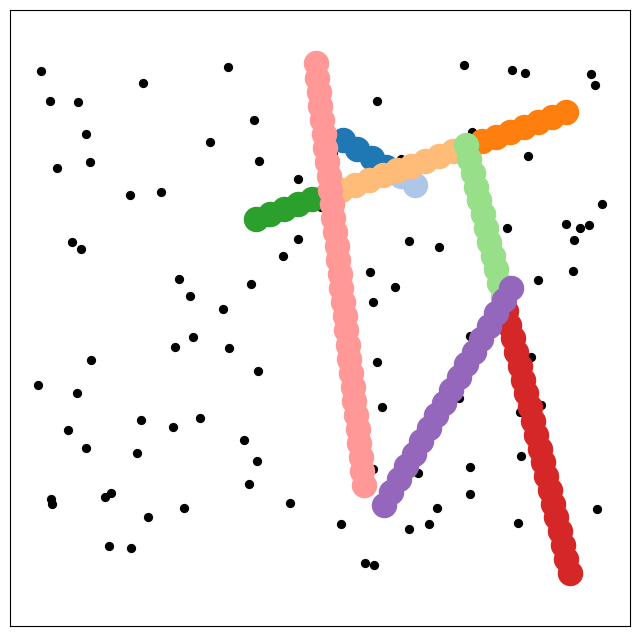

In [68]:

# plt.ion()

pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in x.nodes(data=True)}
fig, ax = plt.subplots(figsize=(8, 8))

# draw all nodes/vertices in the graph, including those not determined to be 
# part of the objects
nx.draw_networkx(x, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32)

# get each connected subgraph and draw it with a different colour
cc = nx.connected_components(x)
for index, sg in enumerate(cc):
    # print (index, sg)

    if len(sg) <= 1:
        continue

    c_idx = np.array(plt.cm.tab20((index % 20) / 20)).reshape(1, -1)
    sg = x.subgraph(sg).copy()
    nx.draw_networkx(sg, pos=pos, edge_color=c_idx, node_color=c_idx, with_labels=False)

plt.show()

### Repeat on a few graphs at a time:

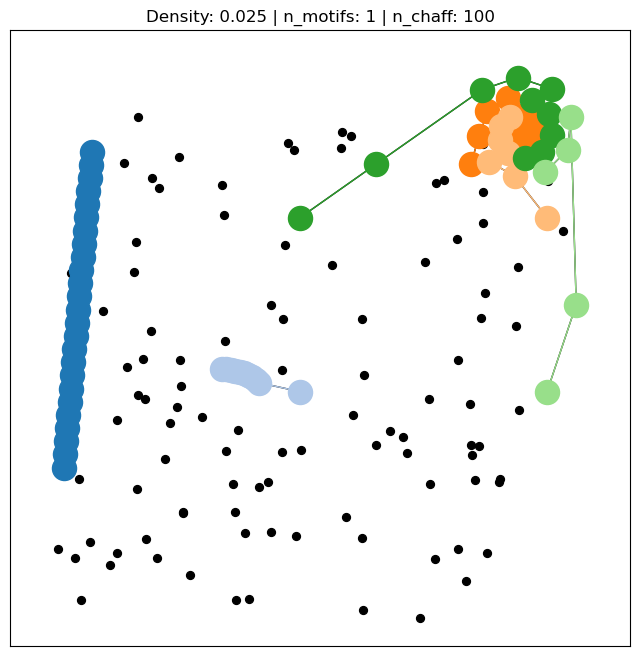

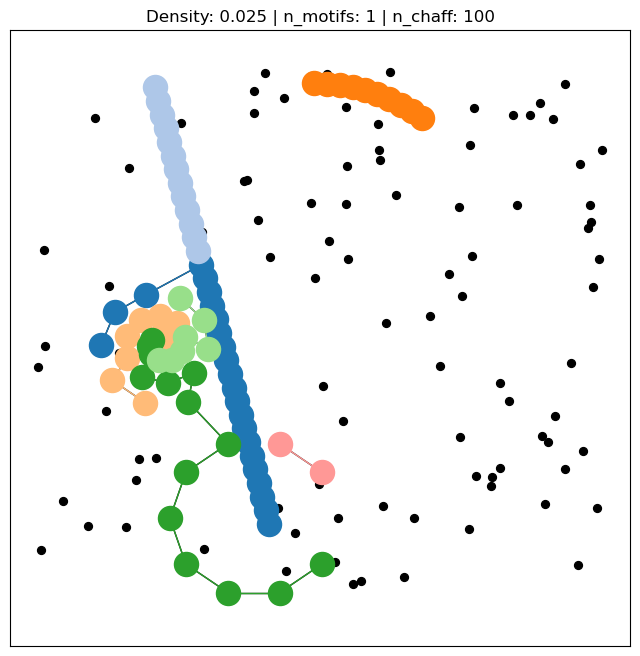

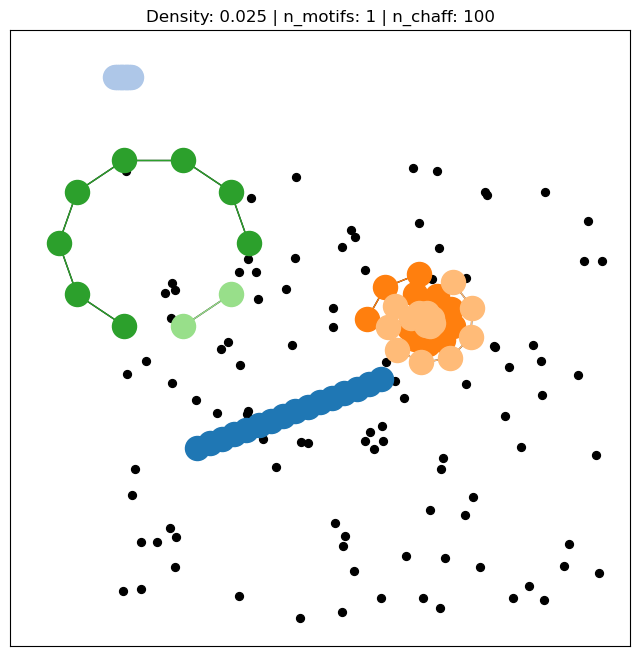

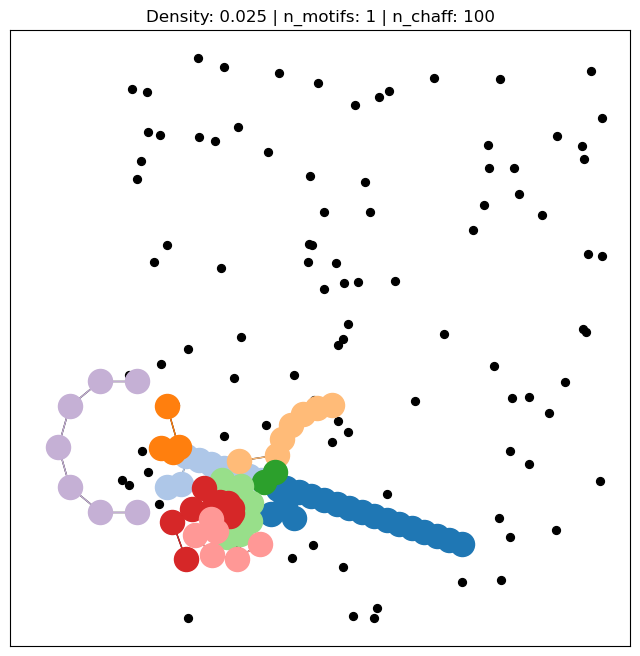

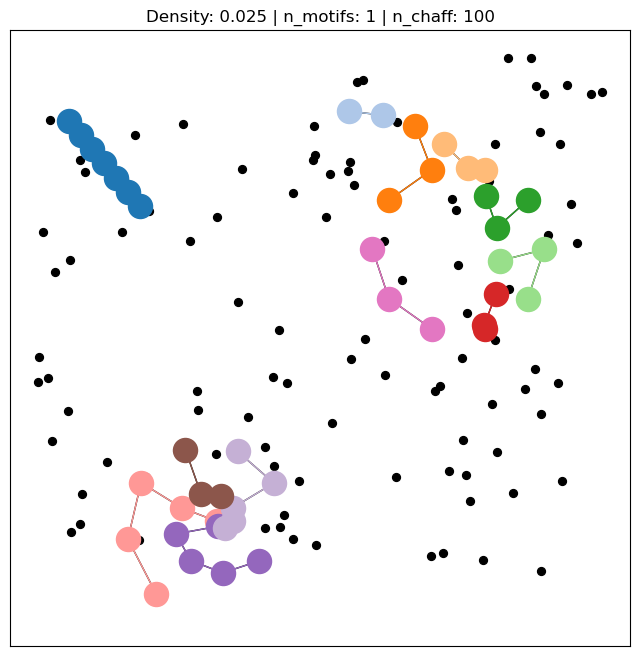

In [69]:
num_trials = 5
density = 0.025
n_motifs = 1
n_chaff = 100

for i in range(num_trials):
    # G = random_graph(n_motifs=n_motifs, n_chaff=n_chaff, scale=1.0, density=density)
    G = random_graph_mixed_motifs(n_motifs=n_motifs, n_chaff=n_chaff, scale=1.0, density=density)
    update_graph_dummy(G)
    x = optimise_graph(G)
    
    # Plot:
    pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in x.nodes(data=True)}
    fig, ax = plt.subplots(figsize=(8, 8))

    # draw all nodes/vertices in the graph, including those not determined to be 
    # part of the objects
    nx.draw_networkx(x, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32)

    # get each connected subgraph and draw it with a different colour
    cc = nx.connected_components(x)
    for index, sg in enumerate(cc):
        
        if len(sg) <= 1:
            continue

        c_idx = np.array(plt.cm.tab20((index % 20) / 20)).reshape(1, -1)
        sg = x.subgraph(sg).copy()
        plt.title(f"Density: {density} | n_motifs: {n_motifs} | n_chaff: {n_chaff}")
        nx.draw_networkx(sg, pos=pos, edge_color=c_idx, node_color=c_idx, with_labels=False)

    plt.show()